# Description
This will focus on using classic regression models and bayesian models. 

#### NOTE: As described in EDA notebook, "Pseudo_ts" is concatenation of data from locally adjacent ski resorts (e.g., all resorts in Colorado) into a single timeseries.
# Imports

In [1]:
! pip install vapeplot arviz pystan stan_utility

     |████████████████████████████████| 1.5MB 5.8MB/s 
     |████████████████████████████████| 727kB 42.6MB/s 
     |████████████████████████████████| 4.3MB 34.1MB/s 
     |████████████████████████████████| 296kB 40.6MB/s 
  Created wheel for vapeplot: filename=vapeplot-0.0.8-cp36-none-any.whl size=11017 sha256=6177c6a2dd47500e5503582dcf56e8f21d5102a9ab06e55ffd9b62318979a855
  Stored in directory: /root/.cache/pip/wheels/5e/f5/95/d4cd5d6af4055b9adc70ff5860e557d58f0b3bdab1f7e0362a
Successfully built vapeplot
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1


In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    import os
    from google.colab import drive
    drive.mount('/content/gdrive')
    base_path = r'/content/gdrive/My Drive/data_sci/colab/ski/'
    os.chdir(base_path)
    try:
        ! git clone https://github.com/chrisoyer/ski-snow-modeling/
    #normal try/except doesn't work on 'fatal' error
    except:
        ! git pull
    mod_path = os.path.join(base_path, 
                            r"ski-snow-modeling/src/analysis/project_utils/project_utils.py")
    import importlib.util
    spec = importlib.util.spec_from_file_location(name="utils.name", location=mod_path)
    utils = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(utils)
    
    os.chdir('./ski-snow-modeling/src/analysis/')
    # Change the working directory to the repo root.
    # Add the repo root to the Python path.
    import sys
    sys.path.append(os.getcwd())
else:
    # local running
    import project_utils as utils

Mounted at /content/gdrive
fatal: destination path 'ski-snow-modeling' already exists and is not an empty directory.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
!git pull

remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 16 (delta 5), reused 2 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), done.
From https://github.com/chrisoyer/ski-snow-modeling
   fc681f5..4750859  master     -> origin/master
 * [new branch]      dependabot/pip/notebook-6.1.5 -> origin/dependabot/pip/notebook-6.1.5
Updating fc681f5..4750859
Fast-forward
 README.md                    |   5 +-
 src/analysis/snow_stan.ipynb | 892 ++++++++++++++++++++++++++-----------------
 2 files changed, 544 insertions(+), 353 deletions(-)


In [18]:
# data wrangling
import numpy as np
import pandas as pd
import os.path
import pickle
import calendar
from typing import Union
import datetime as dt

# viz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import vapeplot
import arviz as az

# modeling
import pystan
import stan_utility
from sklearn.metrics import r2_score

# project specific
from project_utils.project_utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameters

In [5]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')
plt.rc('figure', figsize=(11.0, 7.0))

# Load Data

In [6]:
file_path = r'../../data/snow_data_clean.parquet'
all_data_path = os.path.join(os.getcwd(), file_path)
model_path = r'./stan_model.pkl'
result_path = r'../../data/processed/stan_results.pkl'

In [7]:
# parquet opening is broken on colab
with open(file_path, 'rb') as parq_file:
    long_series_df = pd.read_parquet(parq_file)
assert long_series_df.base.isna().sum()==0

# Feature Engineering

In [21]:
def time_and_shape_log(f):
    """logs time taken by, and out shape for function
    use as decorate for piped functions in data pipeline"""
    def wrapper(dataf, *args, **kwargs):
        tic = dt.datetime.now()
        result = f(dataf, *args, **kwargs)
        toc = dt.datetime.now()
        out_type = type(result)
        print(f"{f.__name__}: time={toc-tic}, type={out_type}, shape={result.shape}")
        return result
    return wrapper

def column_log(f):
    """logs existing columns"""
    def wrapper(dataf, *args, **kwargs):
        print(f"{f.__name__} is taking: {dataf.columns}")
        return f(dataf, *args, **kwargs)
    return wrapper
        
@time_and_shape_log
def add_month(data: pd.DataFrame) -> pd.DataFrame:
    return data.assign(month=lambda x:
                       x.pseudo_ts.dt.month)
@column_log
@time_and_shape_log
def add_diff(data: pd.DataFrame, include_ar: Union[bool, int]=False) -> pd.DataFrame:
    """ use difference in base, not absolute value. can ad Autoregressive features to make modeling easier. 
    Arguments:
        data: df to operate on
        include_ar: include no (False) or 1 or more AR features
    Returns: dataframe with difference and possibly AR terms, but without actual base depth
    """
    data = data.sort_by(['station', 'pseudo_ts'], asc=True)
    groups = data.groupby(['station', 'pseudo_ski_yr'])
    groups = groups.assign(date_diff=lambda x: x.pseudo_ts.diff(1),
                           delta_base=lambda x: x.base.diff(1))
    if include_ar:
        for reg_term in include_ar:
            groups[f"ar_{reg_term}"] = groups.pseu, data.base.diff(1), 0)
    return (pd.concat(groups, axis=0)
            .assign(delta_base=lambda x: np.where(x.date_diff!=1, 0, x.delta_base))
            .fillna(0)
            .drop(columns=['base', 'date_diff'])
           )

@time_and_shape_log
def ohe(data: pd.DataFrame, col: str) -> pd.DataFrame:
    """One hot encodes <col> columns
    """
    return pd.concat([data.drop(columns=[col]),
                      pd.get_dummies(data[col],
                                     prefix=col)],
                     axis=1)
    
@time_and_shape_log
def monthly_mixture(df: pd.DataFrame) -> pd.DataFrame:
    """similar to one hot encoding for month features, but weights on distance from
    15th of month on either side, instead of binary month feature"""
    assert "month" in df.columns
    def month_fixer(ser: pd.Series)-> pd.Series:
        # changes out of bounds month value to allowable values
        ser = np.where(ser>12, ser-12, ser)
        return np.where(ser<1, ser+12, ser)
         
    df = (df.assign(day=lambda x: x.pseudo_ts.dt.day)
            .assign(dist_to_15=lambda x: x.day-15)
            .assign(in_first_half=lambda x: x.dist_to_15<0 )
            .assign(current_mo_weight=lambda x: (30-np.absolute(x.dist_to_15))/30)
            .assign(secondary_mo_weight=lambda x: 1-x.current_mo_weight)
            .assign(secondary_mo=lambda x: month_fixer(np.where(x.in_first_half, x.month-1, x.month+1)))
            )
    for month in range(1, 13):
        df[f"month_{month}"] = np.where(df.month==month, df.current_mo_weight, 0)
        df[f"month_{month}"] = np.where(df.secondary_mo==month, df.secondary_mo_weight, df[f"month_{month}"])
    return df.drop(columns=['dist_to_15', 'in_first_half', 'current_mo_weight', 'secondary_mo_weight',
                            'secondary_mo', 'day'])
    
@time_and_shape_log
def add_month_x_snowfall(data: pd.DataFrame) -> pd.DataFrame:
    """adds interaction terms"""
    months = [col for col in data.columns
              if 'month_' in col]
    combos_df = pd.concat([pd.Series(data.snowfall * data[month],
                                     name='snowfall_x_' + month)
                           for month in months], axis=1)
    return pd.concat([data, combos_df], axis=1)

    
@time_and_shape_log
def cleaner(data: pd.DataFrame, includes: list=[None]) -> pd.DataFrame:
    """ Removes interpolated rows and unneeded columns
    Params:
        data: df to operate on
        includes: column names NOT to drop (don't need to specify usually)
    ski_yr is needed for test/train split"""
    data = data.query('basecol_interpolated==False')
    bad_cols = ['dayofyr', 'station', 'state', 'pseudo_ski_yr',
                'timestamp', 'basecol_interpolated', #need for grouping:'pseudo_ts',
                'pseudo_ts_delt', 'month'
               ]
    bad_cols = [col for col in bad_cols if col not in includes]
    return data.drop(columns=bad_cols)
    
@time_and_shape_log
def sample_weighted_season(df: pd.DataFrame)->pd.DataFrame:
    """samples dataframe but doesn't remove rare months and mildly reduces
    amount of semi-rare months"""
    # un-OHE
    df['month'] = df[[c for c in df.columns if "month_" in c and "x_m" not in c]].idxmax(axis=1)
    # define months
    rare_months = [f'month_{i}' for i in range(5,11)]
    semirare_months = ['month_4', 'month_11']
    nonrare_months = ['month_12', 'month_1', 'month_2', 'month_3']
    # split and sample data
    rare_data = df.query('month in @rare_months')
    semirare_data = df.query('month in @semirare_months').sample(frac=.3, axis=0)
    nonrare_data = df.query('month in @nonrare_months').sample(frac=.09, axis=0)
    # recombine
    return pd.concat([rare_data, semirare_data, nonrare_data], axis=0).drop(columns=['month'])

### Split Data and sample dense areas

In [15]:
# I want to oversample rare months, but will want to use the last year as the test set.
long_series_df.query('basecol_interpolated==False')[['ski_yr', 'pseudo_ts', 'snowfall']]\
.assign(month=lambda x: x.pseudo_ts.dt.month)\
.drop(columns=['pseudo_ts'])\
.pivot_table(index=['month'], columns=['ski_yr'], values='snowfall', aggfunc='count')

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


ski_yr,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
month,,,,,,,,,
1,4735.0,6067.0,6227.0,6240.0,6331.0,5975.0,5989.0,5914.0,5840.0
2,4376.0,5545.0,5781.0,5716.0,5484.0,5650.0,5158.0,5277.0,4949.0
3,4491.0,4810.0,5852.0,5795.0,5017.0,4507.0,4608.0,5060.0,5043.0
4,1534.0,1596.0,1798.0,2009.0,1229.0,1318.0,1594.0,1646.0,1703.0
5,162.0,153.0,210.0,266.0,92.0,183.0,178.0,185.0,305.0
6,25.0,17.0,31.0,52.0,12.0,49.0,23.0,26.0,122.0
7,2.0,2.0,4.0,27.0,NaN,1.0,17.0,10.0,31.0
8,NaN,2.0,4.0,NaN,NaN,NaN,1.0,6.0,1.0
9,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0


In [22]:
# set aside some data for multi-step analysis
leaveouts = ['Eldora', 'Seven Springs']
stan_multistep_test_df = (long_series_df.query('station in @leaveouts')
                         .pipe(add_month)
                         .pipe(add_diff)
                         .pipe(ohe, 'region')
                         .pipe(monthly_mixture)
                         .pipe(cleaner))

add_month: time=0:00:00.002169, type=<class 'pandas.core.frame.DataFrame'>, shape=(7323, 13)
wrapper is taking: Index(['dayofyr', 'timestamp', 'base', 'station', 'snowfall', 'ski_yr',
       'state', 'region', 'pseudo_ts_delt', 'pseudo_ski_yr', 'pseudo_ts',
       'basecol_interpolated', 'month'],
      dtype='object')
add_diff: time=0:00:00.103048, type=<class 'pandas.core.frame.DataFrame'>, shape=(7323, 13)
ohe: time=0:00:00.005895, type=<class 'pandas.core.frame.DataFrame'>, shape=(7323, 14)
monthly_mixture: time=0:00:00.028856, type=<class 'pandas.core.frame.DataFrame'>, shape=(7323, 26)
cleaner: time=0:00:00.006857, type=<class 'pandas.core.frame.DataFrame'>, shape=(2409, 18)


In [ ]:
stan_train_df, stan_test_df = (long_series_df
           .drop(index=stan_multistep_test_df.index)
           .pipe(add_month)
           .pipe(add_diff)
           .pipe(ohe, 'region')
           .pipe(monthly_mixture)
           .pipe(cleaner)
           .pipe(train_test_split_ts, exog_cols='all', ski_yr_cutoff=7, as_monthly=False)
           )
stan_train_df = stan_train_df.pipe(sample_weighted_season)

In [ ]:
# provide data including shapes and column type locations to stan

def subsets(df: pd.DataFrame)-> tuple:
    month_cols = [col for col in df.columns if "month" in col]   
    region_cols = [c for c in df.columns if "region" in c]
    X = df.[['snowfall', 'region_Cascades', 'region_Colorado', 'region_East',
       'region_New_England', 'region_Other', 'region_Rockies_Other',
       'region_Sierras', 'region_Utah', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12']]
    Xmonth= X[month_cols]
    Xsnow = X['snowfall']
    Xregion = X[region_cols]
    y = df[['delta_base']]
    return (X, Xmonth, Xsnow, Xregion, y)

X, X_month, X_snow, X_region, y = subsets(stan_train_df)
X_test, X_month_test, X_snow_test, X_region_test, y_test = subsets(stan_test_df)

stan_data = {'N': X.shape[0],
             'K_month': X_month.shape[1],
             'X_month': X_month.to_numpy(),
             'K_reg': X_region.shape[1],
             'X_reg': X_region.to_numpy(),
             'X_snow': X_snow.to_numpy().reshape(-1,1),
             'y': y.to_numpy().reshape(-1),
             }
stan_data_test = {**stan_data,
                  'N_test': X_test.shape[0],
                  'X_month_test': X_month_test.to_numpy(),
                  'X_reg_test': X_region_test.to_numpy(),
                  'X_snow_test': X_snow_test.to_numpy().reshape(-1,1),
                  }

SyntaxError: ignored

# Bayesian Model in Stan (MCMC)
I want to add priors to the model that snowfall should only result in increases in base depth, and monthly effects should only result in reduction (i.e., monthly effect should measure strength of melting.); changes at odds with this should be considered as noise. A bayesian model allows for this.

In [ ]:
functions_block = """// for function
"""
data_block =  """
    // input data passed from Python
    int<lower=1> N;               // number of data observations
    int<lower=1> K_month;         // no of melting predictor
    matrix[N, K_month] X_month;   // predictor for melting features
    int<lower=1> K_reg;           // no of region features
    matrix[N, K_reg] X_reg;       // region predictors
    matrix[N, 1] X_snow;          // snowfall predictor
    vector[N] y;                  // response vector
    
    // test variables
    int<lower=1> N_test;                  // no of test records
    matrix[N_test, K_month] X_month_test; // predictor for melting features
    matrix[N_test, K_reg] X_reg_test;     // region predictors
    matrix[N_test, 1] X_snow_test;
    """
transformed_data_block = """
    matrix[N, K_reg] X_reg_snow;
    row_vector[N] X_snow_rvect = to_row_vector(X_snow);
    matrix[N_test, K_reg] X_reg_snow_test;
    row_vector[N_test] X_snow_rvect_test = to_row_vector(X_snow_test);
    
    for (k in 1:K_reg) {          //  K_regxN * Nx1  T
        for (n in 1:N) {
            X_reg_snow[n,k] = X_snow_rvect[n] * X_reg[n,k];
    }  }
    
    // same, but for test. Should do this with a function...
    for (k in 1:K_reg) {
        for (n in 1:N_test) {
            X_reg_snow_test[n,k] = X_snow_rvect_test[n] * X_reg_test[n,k];
    } }"""
parameters_block = """
    // intercept was causing divergences and coef interpretation 
    // makes more sense without intercept: 
    // I don't expect change in base depth absent melting or snowfall
    vector<upper=0>[K_month] beta_mo;           // coefficients for melting
    vector<lower=0, upper=1>[K_reg] beta_reg_snow;       // coef for region x snow interaction
    real<lower=0> sigma;                        // must be +ve
    real<lower=0> sig_mos;                      // must be +ve
    """
transformed_parameters_block = """ """
model_block_vars = """
    vector[N] mu;                       // y_hat
    """
model_block_eqs = """
    sigma ~ cauchy(0, 10);              // half Cauchy
    sig_mos ~ cauchy(0, 20);
    for (n in 1:K_month) {
        beta_mo[n] ~ normal(0, sig_mos) T[,0]; // sample from normal, only -ve
    }
    // prior on snow columns is beta over [0,1]
    beta_reg_snow ~ beta(2.2, 3);         // reparameterize so this and snow are from beta dist
    mu = X_month*beta_mo + X_reg_snow*beta_reg_snow;
    y ~ normal(mu, sigma);
    """
model_block = model_block_vars + model_block_eqs
generated_quantities_block = """
    vector[N_test] y_test;
    for(n in 1:N_test) {
        y_test[n] = normal_rng(X_month_test[n]*beta_mo + X_reg_snow_test[n]*beta_reg_snow, sigma);
    }
    """
# assemble model
def create_stan_model(functions_block=functions_block, data_block=data_block, 
                      transformed_data_block=transformed_data_block, 
                      parameters_block=parameters_block, 
                      transformed_parameters_block=transformed_parameters_block, model_block=model_block,
                      generated_quantities_block=generated_quantities_block):
    return f'''
    functions {{{functions_block}}}
    data {{{data_block}}}
    transformed data {{{transformed_data_block}}}
    parameters {{{parameters_block}}}
    transformed parameters {{{transformed_parameters_block}}}
    model {{{model_block}}}
    generated quantities {{{generated_quantities_block}}}'''

stan_model_str = create_stan_model(generated_quantities_block=" ")

In [ ]:
sm = pystan.StanModel(model_code=stan_model_str, model_name='stan_model')
stan_model_str

INFO:pystan:COMPILING THE C++ CODE FOR MODEL stan_model_923da53fa29fec0b07185a946c073299 NOW.


"\n    functions {// for function\n}\n    data {\n    // input data passed from Python\n    int<lower=1> N;               // number of data observations\n    int<lower=1> K_month;         // no of melting predictor\n    matrix[N, K_month] X_month;   // predictor for melting features\n    int<lower=1> K_reg;           // no of region features\n    matrix[N, K_reg] X_reg;       // region predictors\n    matrix[N, 1] X_snow;          // snowfall predictor\n    vector[N] y;                  // response vector\n    \n    // test variables\n    int<lower=1> N_test;                  // no of test records\n    matrix[N_test, K_month] X_month_test; // predictor for melting features\n    matrix[N_test, K_reg] X_reg_test;     // region predictors\n    matrix[N_test, 1] X_snow_test;\n    }\n    transformed data {\n    matrix[N, K_reg] X_reg_snow;\n    row_vector[N] X_snow_rvect = to_row_vector(X_snow);\n    matrix[N_test, K_reg] X_reg_snow_test;\n    row_vector[N_test] X_snow_rvect_test = to_row_v

In [ ]:
# avoid recompile if possible
with open(model_path, 'wb') as f:
    pickle.dump(sm, f)

In [ ]:
fit = sm.sampling(data=stan_data_test, iter=2_000, chains=4, n_jobs=-1,
                  sample_file="../../data/processed/stan_samples",
                  control={'adapt_delta': 0.85, # p accepting posterior draw
                           'stepsize': 1,  # just starting stepsize
                          }, 
                  seed=42, verbose=True)

In [ ]:
# for overnight run
try:
    with open(result_path, 'wb') as f:
        pickle.dump(fit, f)
# reload saved objects if not reruning sampler
except NameError:
    with open(model_path, 'rb') as f:
        sm = pickle.load(f)
    with open(result_path, 'rb') as f:
        fit = pickle.load(f)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  after removing the cwd from sys.path.


## MCMC Diagnostics
We will want to check:
1. Model actually runs.
1. Good Mixing of Chains: (fix with stronger prior, reparameterization)
    1. $\hat{R}$ is 1.1 or under for all parameters.
    1. When n_eff / n_transitions < 0.001 the estimators that we use are often biased and can significantly overestimate the true effective sample size.
1. Check tree depth:
if threshold saturated, increase tree depth _control={max_treedepth: 15}_
1. 

_



In [ ]:
stan_utility.check_all_diagnostics(fit)

n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


## Visualization of results

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9ece05390>,
      dtype=object)

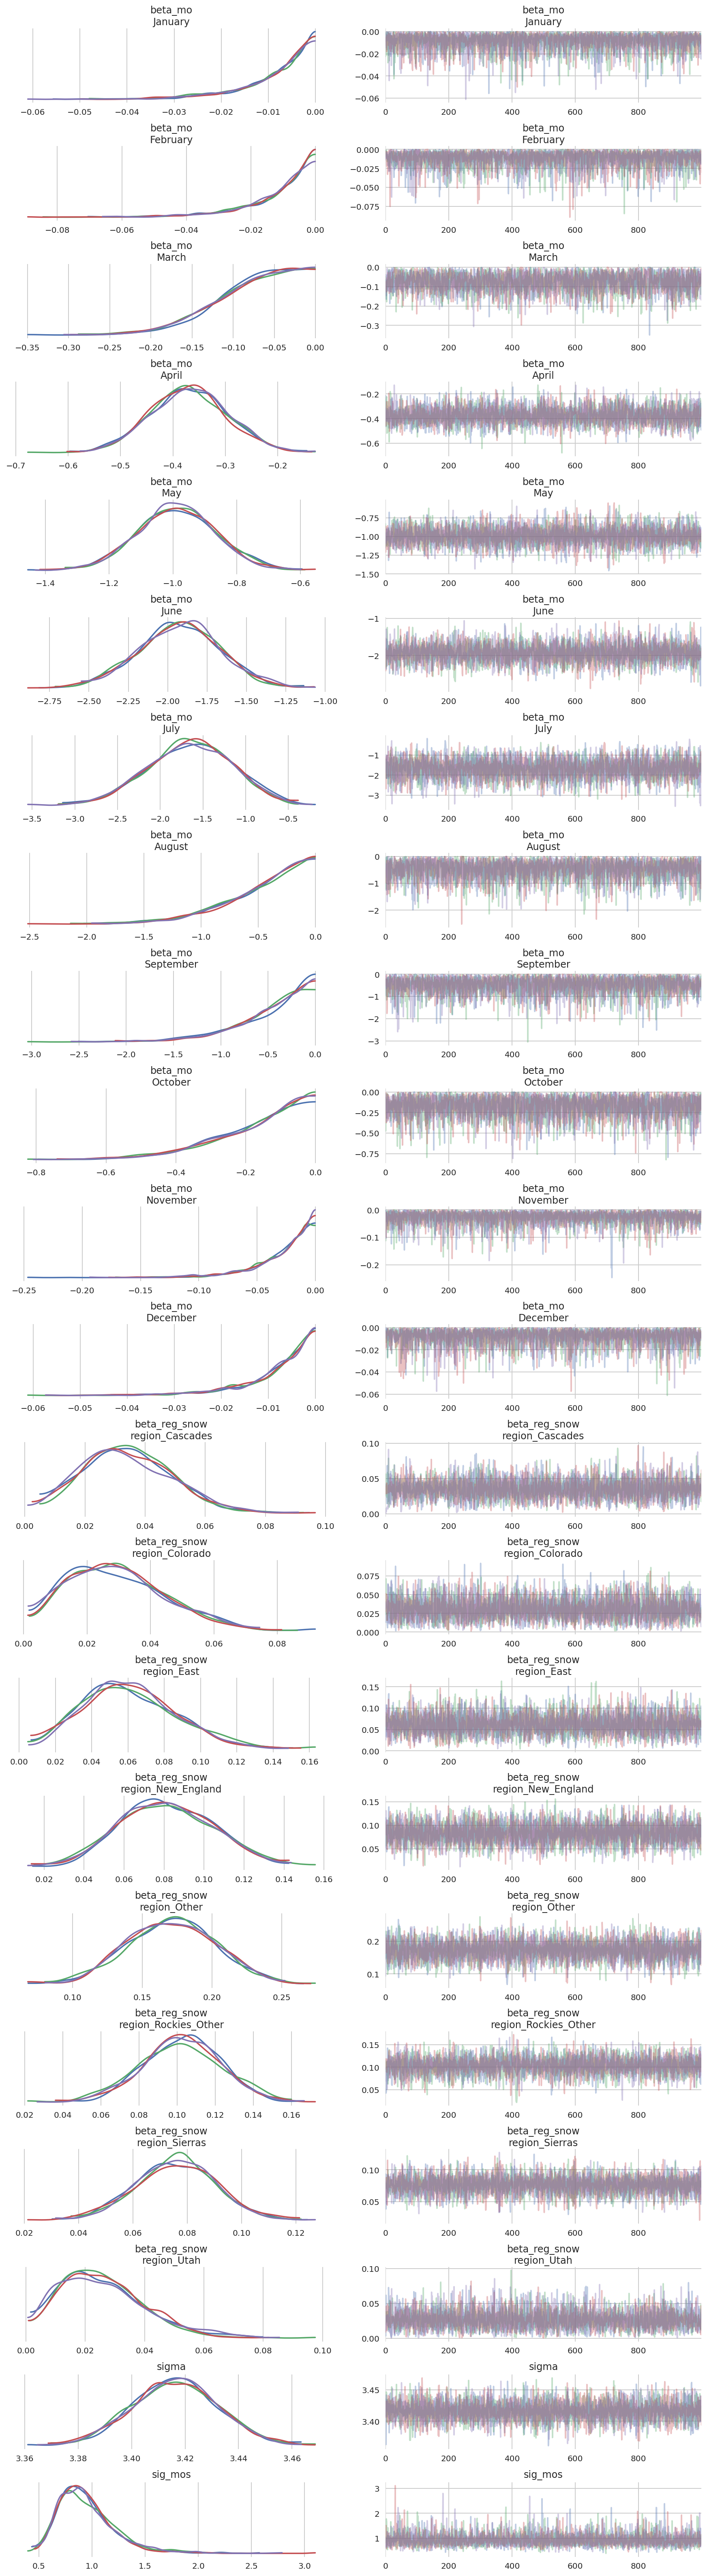

In [ ]:
fit_az = az.from_pystan(posterior=fit,
                        dims={'beta_reg_snow': ['Coefficients_for_Snow_by_Region'],
                              'beta_mo': ['Melting_Coefficients_by_Month']},
                        coords={'Coefficients_for_Snow_by_Region': X_region.columns.values.tolist(),
                                'Melting_Coefficients_by_Month': [calendar.month_name[i+1] for i in range(12)]}
                        )
rc = {'plot.max_subplots': None}
az.rcParams.update(rc)
sns.set_style('whitegrid')
az.plot_trace(fit_az)

In [ ]:
# fix brackets in col nmaes
fit_df = (fit.to_dataframe()
          .rename(columns=lambda x: x.replace("[", "_"))
          .rename(columns=lambda x: x.replace("]", "")))

fit_df.head()

,chain,draw,warmup,beta_mo_1,beta_mo_2,beta_mo_3,beta_mo_4,beta_mo_5,beta_mo_6,beta_mo_7,beta_mo_8,beta_mo_9,beta_mo_10,beta_mo_11,beta_mo_12,beta_reg_snow_1,beta_reg_snow_2,beta_reg_snow_3,beta_reg_snow_4,beta_reg_snow_5,beta_reg_snow_6,beta_reg_snow_7,beta_reg_snow_8,sigma,sig_mos,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,-0.005150,-0.013738,-0.133678,-0.297732,-1.151565,-1.966469,-2.164395,-0.232471,-0.473741,-0.149261,-0.001194,-0.000149,0.036839,0.040759,0.049566,0.081383,0.228989,0.050987,0.091522,0.016476,3.392277,0.978825,-37788.878279,1.000000,0.3009,4,15,0,37801.893789
1,0,1,0,-0.001732,-0.003190,-0.111309,-0.214173,-1.047810,-1.941890,-1.544693,-0.038536,-0.421253,-0.065512,-0.001006,-0.000232,0.034992,0.030357,0.043048,0.115462,0.153087,0.050461,0.093288,0.003661,3.435289,1.044112,-37795.686346,0.930398,0.3009,4,15,0,37802.485702
2,0,2,0,-0.008580,-0.001681,-0.065906,-0.463876,-0.958160,-1.825996,-1.702224,-0.511377,-0.231729,-0.265237,-0.008496,-0.004906,0.041896,0.013110,0.033958,0.053415,0.148646,0.042230,0.038799,0.061738,3.362879,0.622987,-37798.159973,0.947669,0.3009,4,15,0,37811.764220
3,0,3,0,-0.002728,-0.010478,-0.165037,-0.345911,-0.982103,-2.366684,-1.225428,-1.254290,-0.953462,-0.194414,-0.014268,-0.001163,0.039723,0.015906,0.038203,0.052275,0.192711,0.045701,0.065523,0.031933,3.402929,0.844580,-37788.010205,0.997009,0.3009,3,15,0,37811.898180
4,0,4,0,-0.008400,-0.011756,-0.105183,-0.417464,-1.115084,-1.558685,-2.165017,-0.047359,-0.752880,-0.317760,-0.043138,-0.008279,0.020999,0.024284,0.107589,0.043523,0.180071,0.111178,0.092086,0.026730,3.419044,0.978038,-37782.600831,0.982384,0.3009,4,15,0,37795.113186


In [ ]:
# get region names without "region_"
region_names = [reg[7:] for reg in X_region.columns.values.tolist()]

region_betas_df = fit_df.filter(regex="reg", axis=1)
reg_cols = region_betas_df.columns
region_betas_df = (region_betas_df
                   .rename(columns={col: reg_name for col, reg_name 
                                    in zip(reg_cols, region_names)})
                   .melt(var_name="region"))
region_betas_df.head(2)

,region,value
0,Cascades,0.036839
1,Cascades,0.034992


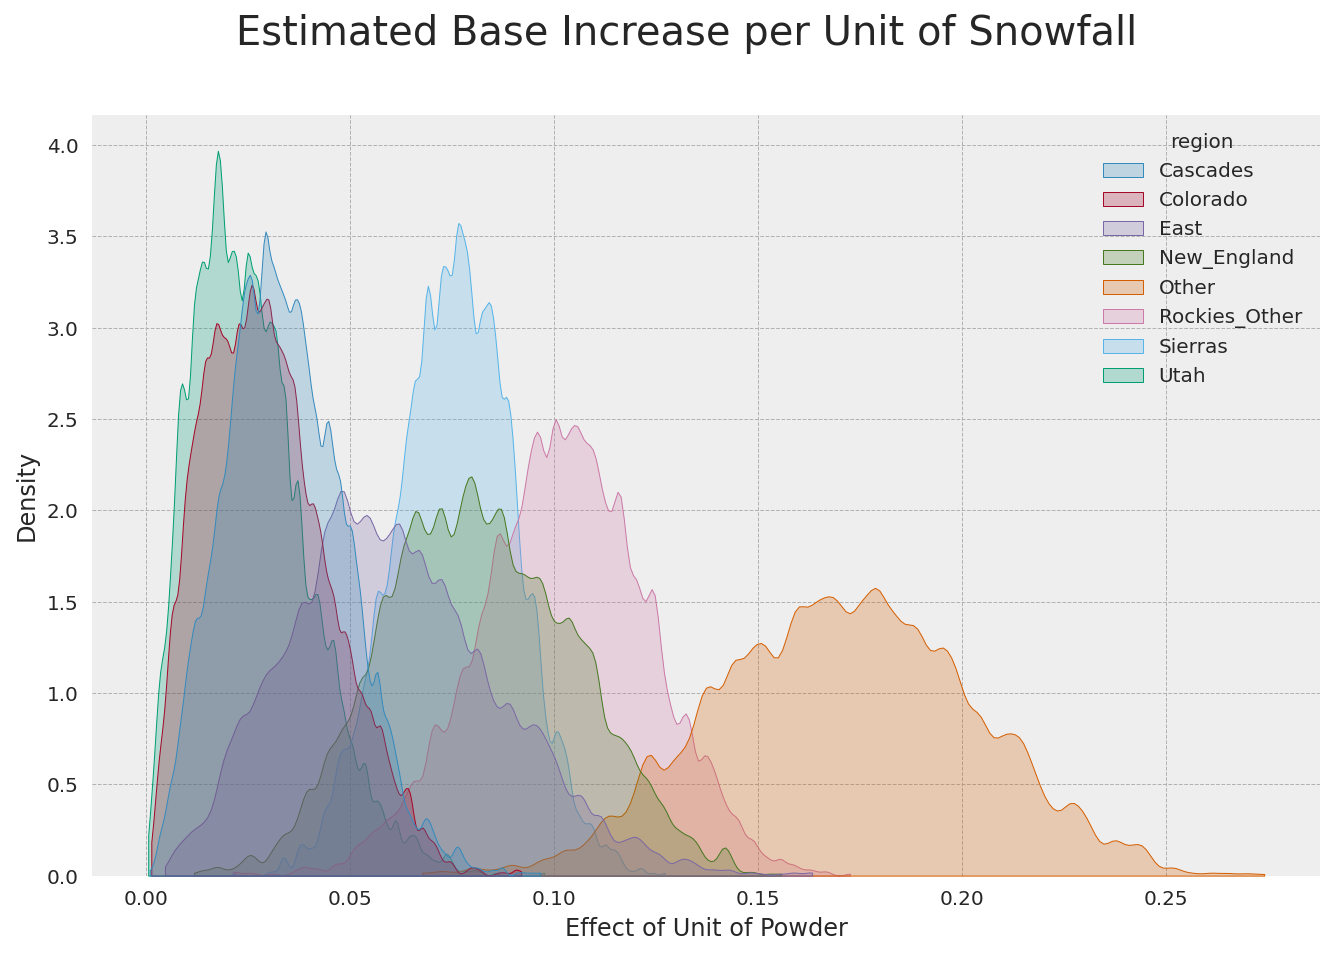

In [ ]:
plt.style.use('bmh')
fig = sns.kdeplot(x=region_betas_df.value, hue=region_betas_df.region, fill=True, cut=0, bw_adjust=.3)
plt.suptitle("Estimated Base Increase per Unit of Snowfall", fontsize=20)
plt.xlabel("Effect of Unit of Powder");

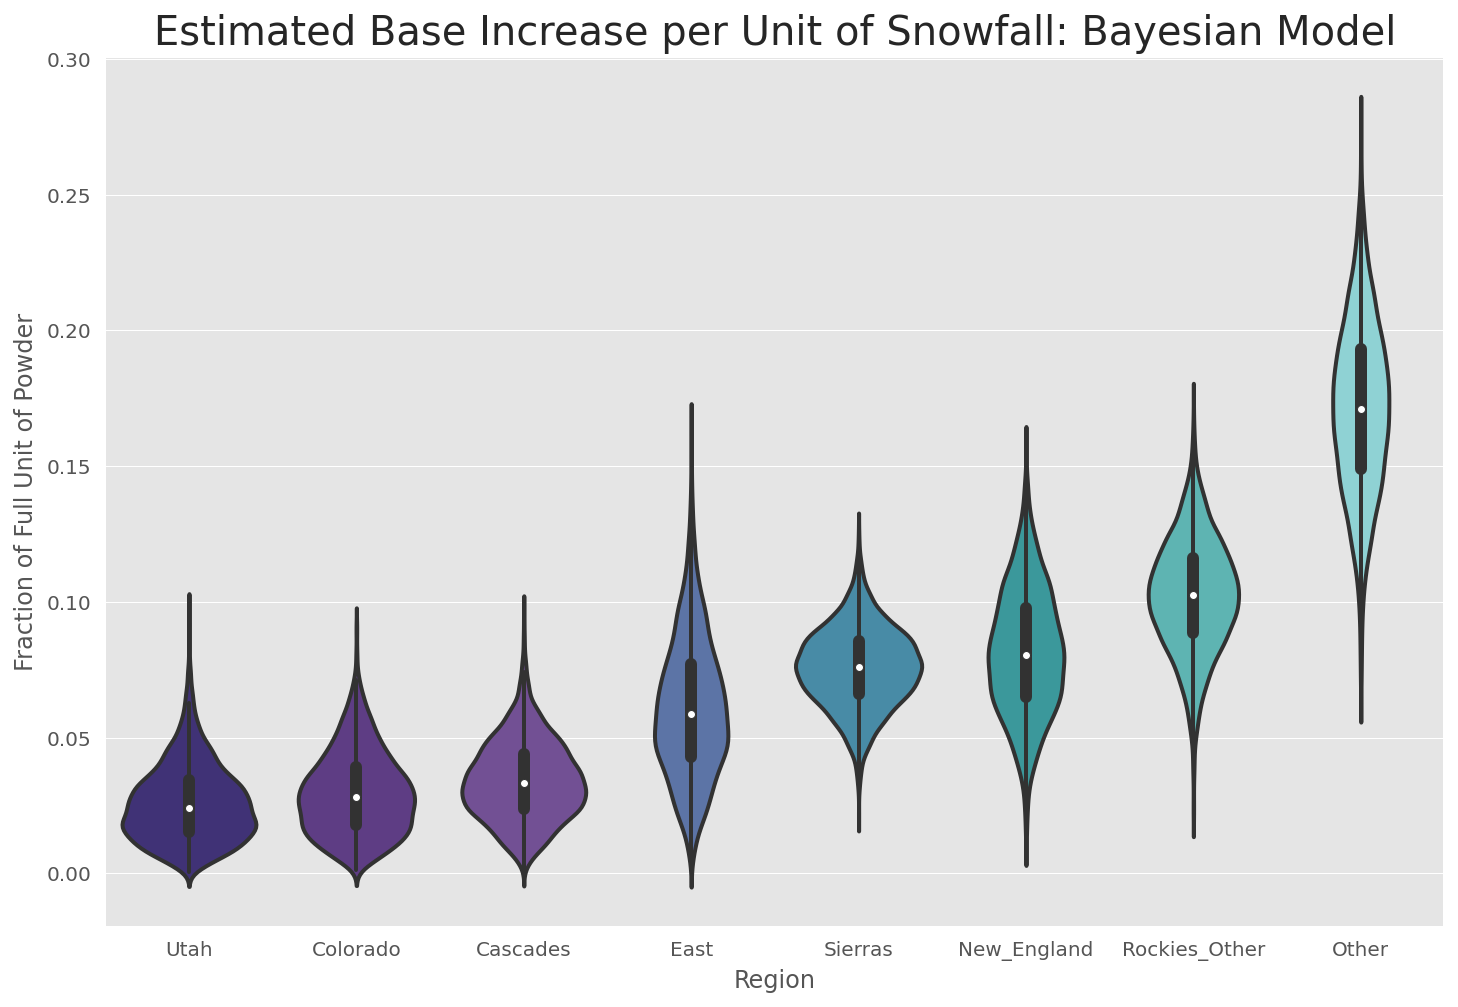

In [ ]:
plt.style.use('ggplot')
jazzcup = sns.blend_palette(vapeplot.palette("jazzcup"), n_colors=region_betas_df.region.unique().size)
f, ax = plt.subplots(figsize=(12, 8))
sort_order = region_betas_df.groupby(['region']).mean().sort_values(by='value', ascending=True).index

sns.violinplot(x='region', y='value', data=region_betas_df,
            order=sort_order, palette=jazzcup)

plt.title("Estimated Base Increase per Unit of Snowfall: Bayesian Model", fontsize=20)
plt.xlabel('Region')
plt.ylabel('Fraction of Full Unit of Powder');

In [ ]:
month_betas_df = fit_df.filter(like='beta_mo').melt(var_name="month")
month_betas_df = month_betas_df[month_betas_df.value > month_betas_df.value.quantile(.02)]
month_map = {f"beta_mo_{i}": calendar.month_abbr[i] for i in range(1, 13)}
#month_betas_df['month'] = pd.to_datetime(month_betas_df['month'].replace(month_map), format="%B").dt.month.astype('category')
month_betas_df['month'] = month_betas_df['month'].replace(month_map).astype('str')
month_betas_df.head()

,month,value
0,Jan,-0.005150
1,Jan,-0.001732
2,Jan,-0.008580
3,Jan,-0.002728
4,Jan,-0.008400


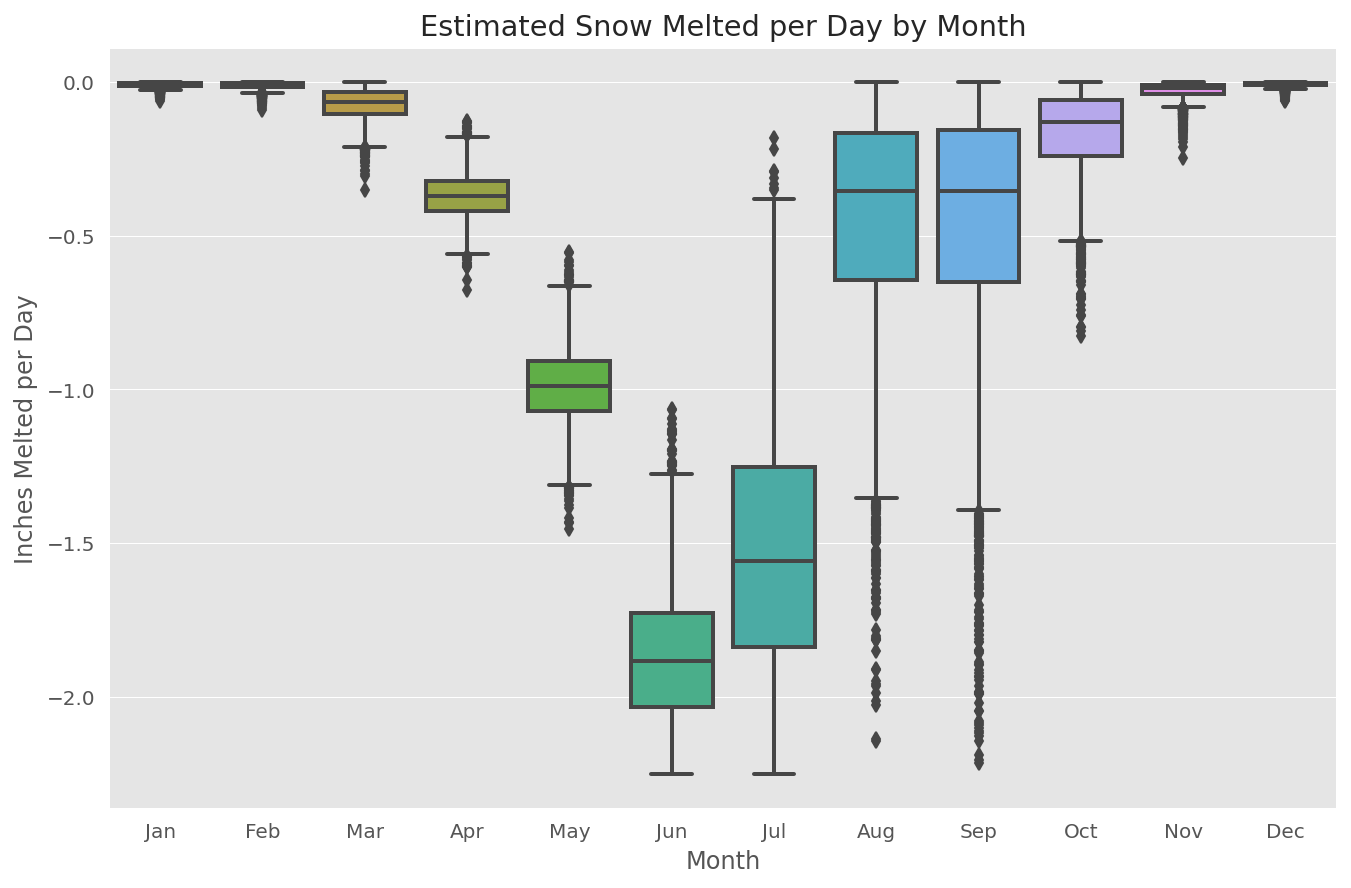

In [ ]:
def plot_snow_betas(df, start_mo):
    fig, ax = plt.subplots()
    month_ordered = [mo for mo in calendar.month_abbr[1:] if mo in df.month.unique()]
    start_mo_ix = month_ordered.index(start_mo)
    month_ordered = month_ordered[start_mo_ix:] + month_ordered[:start_mo_ix]
    sns.boxplot(data=df, y='value', x='month', order=month_ordered,
                ax=ax, )
    ax.set_ylabel('Inches Melted per Day')
    ax.set_xlabel('Month')
    ax.set_title('Estimated Snow Melted per Day by Month');
plot_snow_betas(month_betas_df, "Jan")

These estimates are mostly expected, but there seems to be low melting amounts during summer...this can be explained when we realize that most of the values for July-Sept are from the handful of resorts with glacier skiing. The averages aren't weighted by ski acreage, so the large number of small ski stations on the east coast & midwest with short seasons are disproportionately affecting these numbers. We could extend the model by breakin out melting to just the interaction of month x region.

NameError: ignored

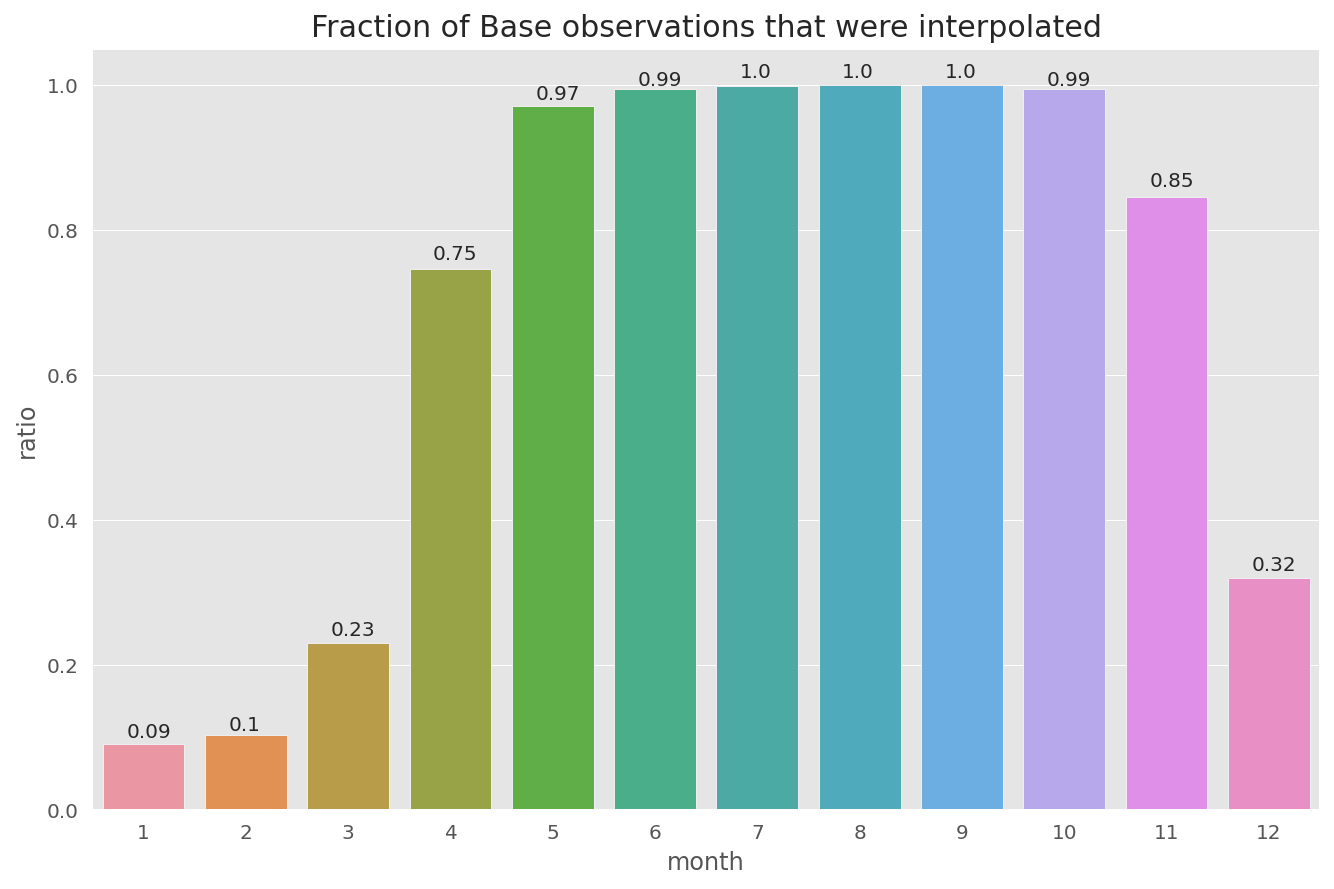

In [ ]:
interpo_ratios=(long_series_df
    .assign(month=lambda x: x.pseudo_ts.dt.month)
    .groupby('month')
    .apply(lambda x: x.basecol_interpolated.sum()/x.shape[0])
    .to_frame()
    .reset_index()
    .rename(columns={0:'ratio'})
)
fig, ax = plt.subplots()
sns.barplot(data=interpo_ratios, x='month', y='ratio', ax=ax)
plt.title('Fraction of Base observations that were interpolated', fontsize=15)
[plt.text((i-.17), value+.01, str(value)) for i, value in enumerate(interpo_ratios.ratio.round(2).to_numpy())]
months_xticks(ax);

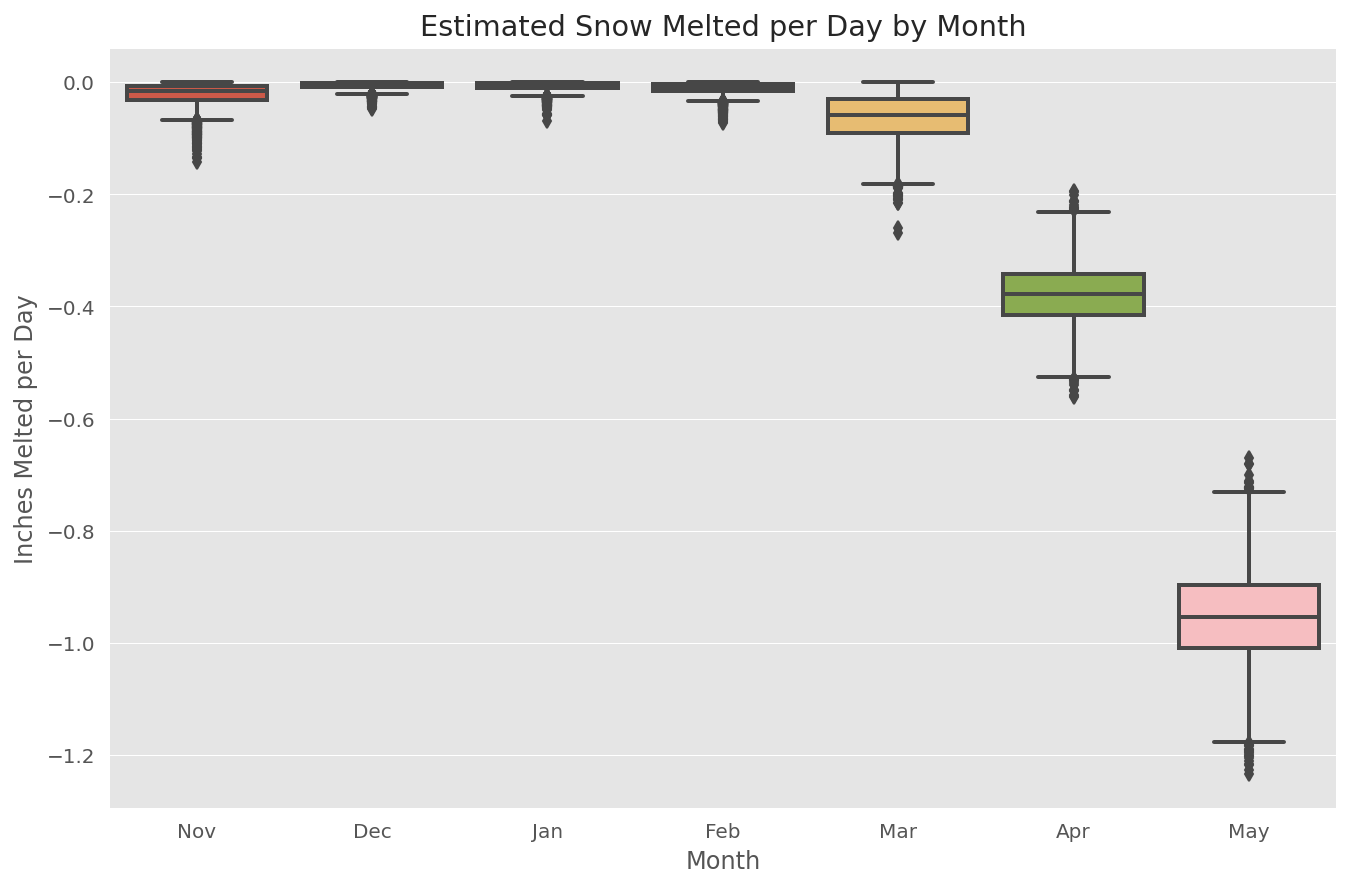

In [ ]:
plot_snow_betas(month_betas_df[~month_betas_df.month.isin(['Jun', 'Jul', 'Aug', 'Sep', 'Oct'])], "Nov")

### Check test set metrics

In [ ]:
stan_model_wtest_str = create_stan_model()
sm_wtest = pystan.StanModel(model_code=stan_model_wtest_str, model_name='stan_model_wtest')
fit_wtest = sm_wtest.sampling(data=stan_data_test, iter=2_000, chains=4, n_jobs=-1,
                  sample_file="../../data/processed/stan_samples",
                  control={'adapt_delta': 0.85, # p accepting posterior draw
                           'stepsize': 1,  # just starting stepsize
                          }, 
                  seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL stan_model_wtest_73a6652800700af1bc486cafd8bdc311 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [ ]:
def model_score(fit_object=fit_wtest, input_data=stan_test_df) -> None:
    y_pred = pd.DataFrame(data=fit_object.extract(['y_test'], inc_warmup=False)['y_test'].T.mean(axis=1),
                      columns=['y_pred'])
    y_true = stan_test_df[['pseudo_ts', 'delta_base']]
    y_true.index = pd.to_datetime(y_true.index)
    print(f"R2 score for model: {r2_score(y_true=y_true.delta_base, y_pred=y_pred)}")
    #y_true_monthly = y_true.resample('M', on='pseudo_ts').mean()
    y_pred_w_old = (pd.concat([y_pred.reset_index(drop=True),
                              y_true.reset_index(drop=True)],
                              axis=1, ignore_index=True)
                    .rename(columns={0:'y_pred', 1: 'pseudo_ts', 2: 'y_true'})
                    #.replace(([np.inf, -np.inf], np.nan))
                    #.dropna()
                    .set_index('pseudo_ts'))
    y_monthly = y_pred_w_old.resample('M').mean().dropna()    
    print(f"R2 score aggregated by month: {r2_score(y_true=y_monthly.y_true, y_pred=y_monthly.y_pred)}") 
model_score()

R2 score for model: 0.004504206777743991
R2 score aggregated by month: 0.29038272867723647


# Stan model including ARMA terms
I will not be using a seasonal model, since I think using months as predictors is more useful to capture seasonal changes in an interpretable way. However, I do want to caputure ARMA terms to improve model performance.

AttributeError: ignored

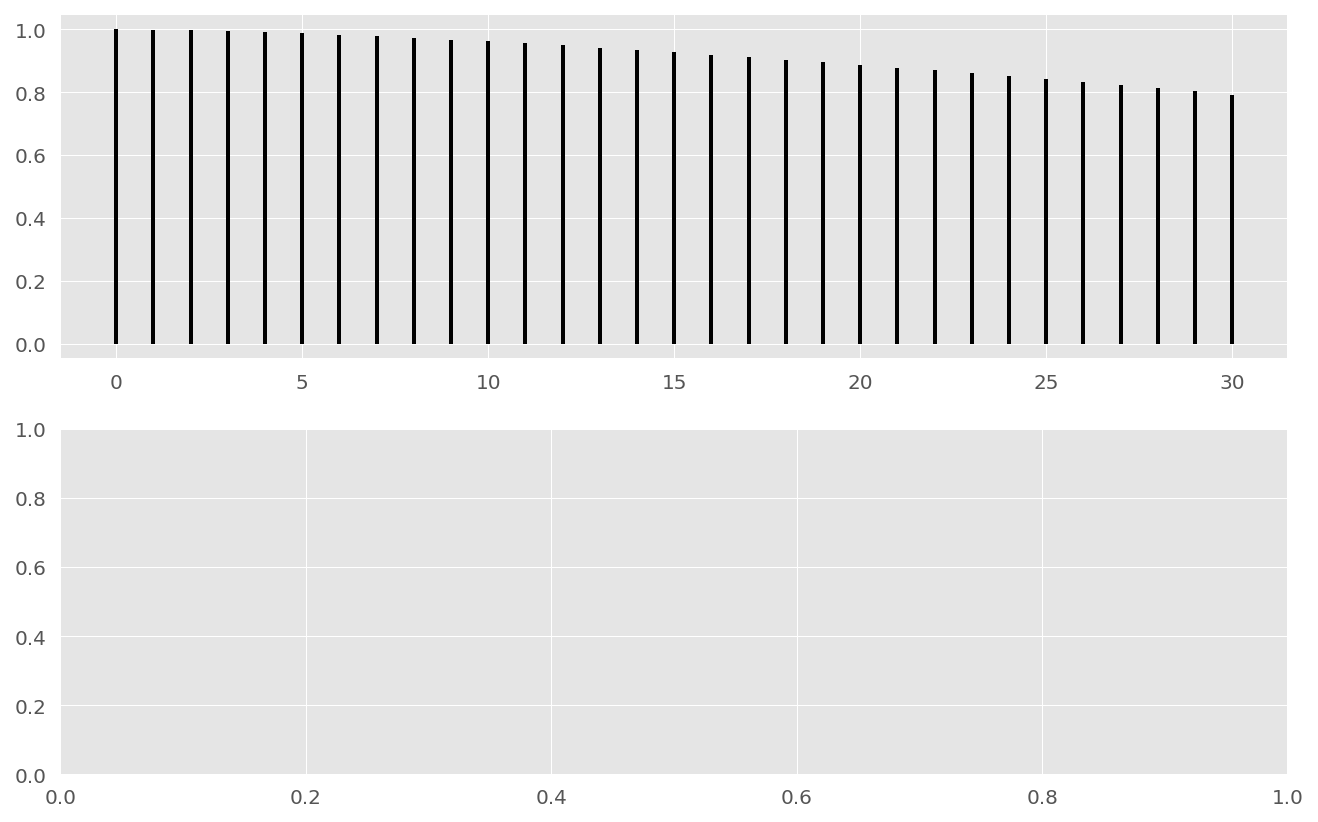

In [ ]:
AC_PAC_plotter(df=long_series_df.query('ski_yr==1')[['base']], differences=1)

There is a long decay in the ACF, and a single (not including the 0 lag) positive PACF correlation. This is a classic AR(1) signature, so I will add that to the model. Adding another differencing term might be even better, but then all of the coefficients would lose the usefulness of their interpretability.

In [ ]:
model_block_vars_ar = model_block_vars + """real beta_ar;   // coefficient for AR(1)"""
model_block_eqs_ar = """
    for (n in 2:K_month) {
        beta_mo[n] ~ normal(0, sig_mos) T[,0]; // sample from normal, only -ve
    }
    // prior on snow columns is beta over [0,1]
    beta_reg_snow ~ beta(2.2, 3);
    
    mu = X_month*beta_mo + X_reg_snow*beta_reg_snow;
    y[2:N] ~ normal(mu + y[1:(N - 1)]*beta_ar, sigma);
    """
model_block_ar = model_block_vars_ar + model_block_eqs_ar

generated_quantities_ar = """
    vector[N_test] y_test;
    for(n in 2:N_test) {
        y_test[n] = normal_rng(X_month_test[n]*beta_mo + X_reg_snow_test[n]*beta_reg_snow + y_test, sigma);
    }
"""

In [ ]:
stan_model_ar_str = create_stan_model(model_block=model_block_ar)
print(stan_model_ar_str)


    functions {// for function
}
    data {
    // input data passed from Python
    int<lower=1> N;               // number of data observations
    int<lower=1> K_month;         // no of melting predictor
    matrix[N, K_month] X_month;   // predictor for melting features
    int<lower=1> K_reg;           // no of region features
    matrix[N, K_reg] X_reg;       // region predictors
    matrix[N, 1] X_snow;          // snowfall predictor
    vector[N] y;                  // response vector
    
    // test variables
    int<lower=1> N_test;                  // no of test records
    matrix[N_test, K_month] X_month_test; // predictor for melting features
    matrix[N_test, K_reg] X_reg_test;     // region predictors
    matrix[N_test, 1] X_snow_test;
    }
    transformed data {
    matrix[N, K_reg] X_reg_snow;
    row_vector[N] X_snow_rvect = to_row_vector(X_snow);
    matrix[N_test, K_reg] X_reg_snow_test;
    row_vector[N_test] X_snow_rvect_test = to_row_vector(X_snow_test);
    

In [ ]:
sm_ar = pystan.StanModel(model_code=stan_model_ar_str, model_name='stan_model_ar')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL stan_model_ar_2a07afeacdfb92ec06891e1f176bedbd NOW.


In [ ]:
fit_ar = sm_ar.sampling(data=stan_data_test, iter=2_000, chains=4, n_jobs=-1,
                  sample_file="../../data/processed/stan_samples",
                  control={'adapt_delta': 0.85, # p accepting posterior draw
                           'stepsize': 1,  # just starting stepsize
                          }, 
                  seed=42, verbose=True)

RuntimeError: ignored

In [ ]:
stan_utility.check_all_diagnostics(fit_ar)

In [ ]:
fit_ar.extract(['y_test'])

In [ ]:
model_score(fit_object=fit_ar)